# Titanic challenge part 2
In this kernel, we will be covering all of the steps required to train, tune and assess a random forest model. 

[**Part 1**](https://www.kaggle.com/jamesleslie/titanic-eda-wrangling-imputation/notebook) of this series dealt with the pre-processing and manipulation of the data. This notebook will make use of the data sets that were created in the first part.   

We will do each of the following:
  - train and test default RF model
  - introduce cross-validation for model training
  - use grid search to optimize hyperparameters
  - submit our predictions for the test set
  
[**Part 3**](https://www.kaggle.com/jamesleslie/titanic-neural-network-for-beginners/notebook) of this challenge involves fitting and tuning a **neural network** to make predictions.

# Table of Contents:

- **1. [Load packages and data](#loading)**
- **2. [Pre-processing](#pre-processing)**
- **3. [Random Forest](#random-forest)**
  - **3.1. [Train/test split](#train-test)**
  - **3.2. [Cross-validation](#cv)**
  - **3.3. [Grid search](#grid-search)**
- **4. [Submit predictions](#submission)**

<a id="loading"></a>
# 1. Load packages and data
We will be using the train and test sets that we created in [part 1](https://www.kaggle.com/jamesleslie/titanic-eda-wrangling-imputation/notebook) of this series.   

You can find the dataset [here](https://www.kaggle.com/jamesleslie/titanic-cleaned-data).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline
rcParams['figure.figsize'] = 10,8
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
# print(os.listdir("../input"))

In [2]:
#print(os.listdir("../input/titanic-cleaned-data"))

In [3]:
# Load data as Pandas dataframe
train = pd.read_csv('train_clean.csv', )
test = pd.read_csv('test_clean.csv')
df = pd.concat([train, test], axis=0, sort=True)

In [4]:
df.head()

,Age,Cabin,Embarked,Family_Size,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,1,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,1,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,0,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,1,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,0,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


In [5]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

        
display_all(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1309,NaN,NaN,NaN,29.5624,13.1654,0.17,22,30,35.5,80
Cabin,295,186,C23 C25 C27,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,1309,3,S,915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Family_Size,1309,NaN,NaN,NaN,0.883881,1.58364,0,0,0,1,10
Fare,1308,NaN,NaN,NaN,33.2955,51.7587,0,7.8958,14.4542,31.275,512.329
Name,1309,1307,"Kelly, Mr. James",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parch,1309,NaN,NaN,NaN,0.385027,0.86556,0,0,0,0,9
PassengerId,1309,NaN,NaN,NaN,655,378.02,1,328,655,982,1309
Pclass,1309,NaN,NaN,NaN,2.29488,0.837836,1,2,3,3,3
Sex,1309,2,male,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df['Survived'].value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

<a id="pre-processing"></a>
# 2. Encode categorical variables
We need to convert all categorical variables into numeric format. The categorical variables we will be keeping are `Embarked`, `Sex` and `Title`.   

The `Sex` variable can be encoded into single 1-or-0 column, but the other variables will need to be [one-hot encoded](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f). Regular label encoding assigns some category labels higher numerical values. This implies some sort of scale (Embarked = 1 is not **more** than Embarked = 0 - it's just _different_). One Hot Encoding avoids this problem.   

We will assume that there is some ordinality in the `Pclass` variable, so we will leave that as a single column.

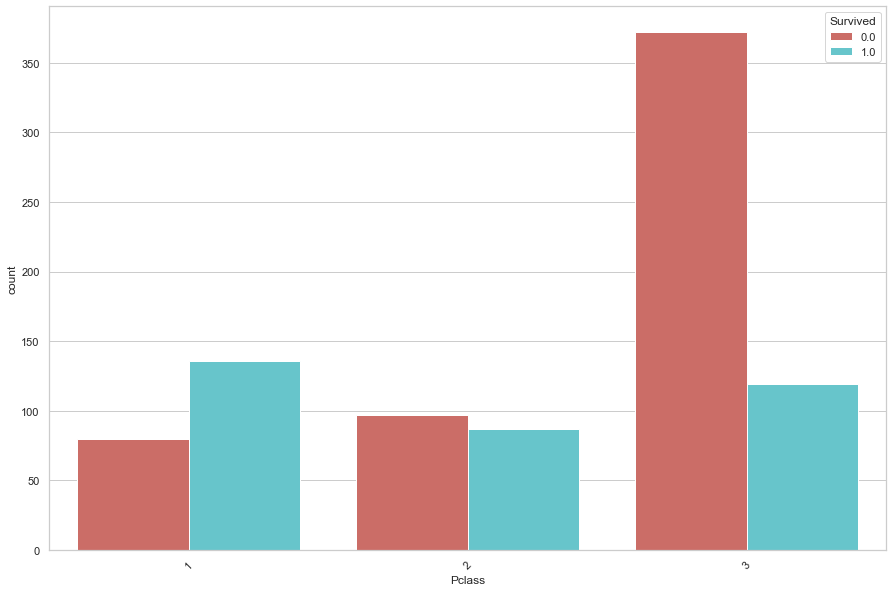

In [7]:
sns.countplot(x='Pclass', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

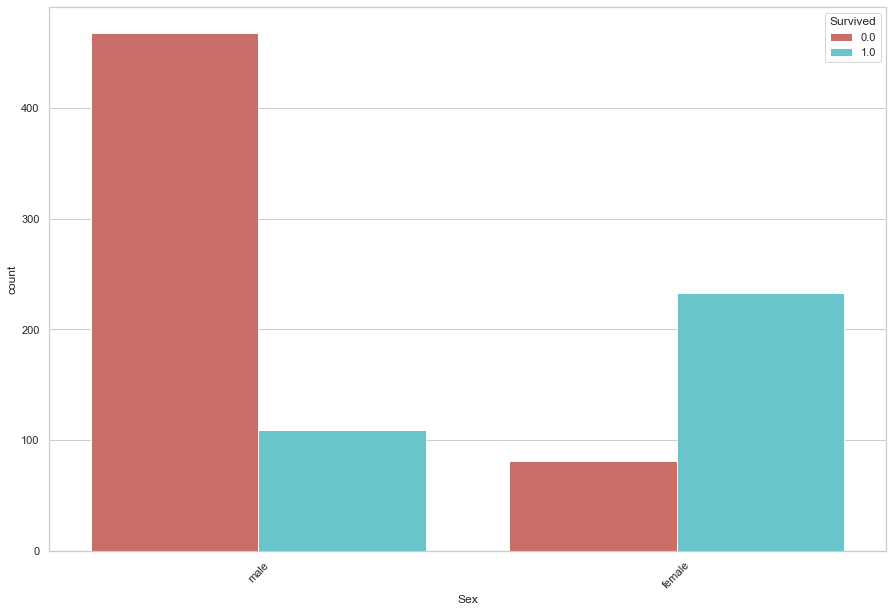

In [8]:
sns.countplot(x='Sex', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

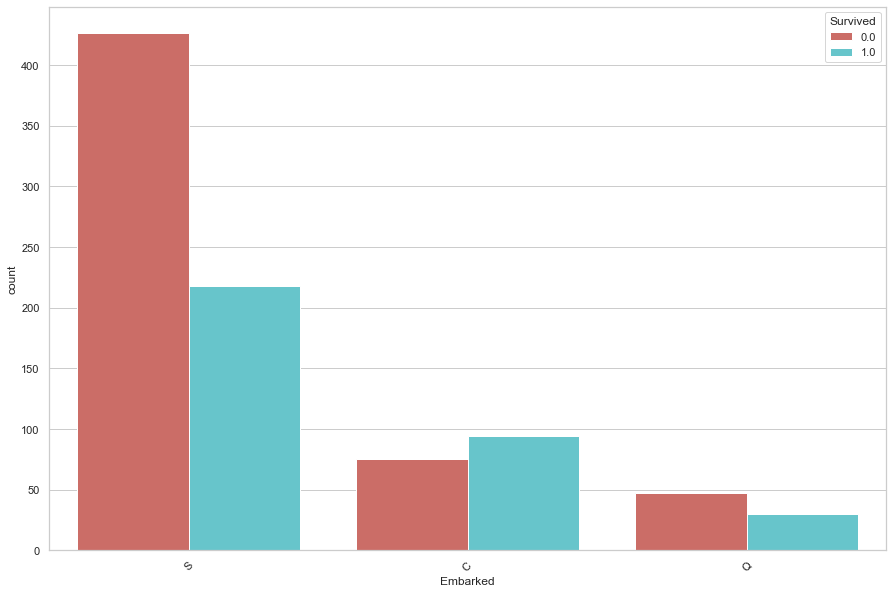

In [9]:
sns.countplot(x='Embarked', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

In [10]:
# convert to category dtype
df['Sex'] = df['Sex'].astype('category')
# convert to category codes
df['Sex'] = df['Sex'].cat.codes

In [11]:
# subset all categorical variables which need to be encoded
categorical = ['Embarked', 'Title']

for var in categorical:
    df = pd.concat([df, 
                    pd.get_dummies(df[var], prefix=var)], axis=1)
    del df[var]

In [12]:
# drop the variables we won't be using
df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [13]:
df.head()

,Age,Family_Size,Fare,Parch,Pclass,Sex,SibSp,Survived,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,22.0,1,7.2500,0,3,1,1,0.0,0,0,1,0,0,0,1,0,0
1,38.0,1,71.2833,0,1,0,1,1.0,1,0,0,0,0,0,0,1,0
2,26.0,0,7.9250,0,3,0,0,1.0,0,0,1,0,0,1,0,0,0
3,35.0,1,53.1000,0,1,0,1,1.0,0,0,1,0,0,0,0,1,0
4,35.0,0,8.0500,0,3,1,0,0.0,0,0,1,0,0,0,1,0,0


<a id="random-forest"></a>
# 3. Random Forest
Now, all that is left is to feed our data that has been cleaned, encoded and scaled to a random forest.    
<a id="train-test"></a>
## 3.1. Train/test split
But first, we need to separate *data_df* back into *train* and *test* sets.

In [14]:
train = df[pd.notnull(df['Survived'])]
X_test = df[pd.isnull(df['Survived'])].drop(['Survived'], axis=1)

### Validation set
Since we can't use our test set to assess our model (it doesn't have any labels), we will create a separte 'validation set'. We will use this set to test how our model generalises to unseen data.

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    train.drop(['Survived'], axis=1),
    train['Survived'],
    test_size=0.2, random_state=42)

In [16]:
for i in [X_train, X_val, X_test]:
    print(i.shape)

(712, 16)
(179, 16)
(418, 16)


### Create Random Forest model
We will first make a random forest model, using all of the default parameters.   
> Note: set the `random_state` to 42 for reproducibility

In [17]:
rf = RandomForestClassifier(random_state=42)

### Train model
Now, let's train the model on our training set.

In [18]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Test model

In [19]:
accuracy_score(y_val, rf.predict(X_val))

0.8379888268156425

<a id="cv"></a>
## 3.2. Cross-validation
Keeping a separate validation set means that we have less data on which to train our model. Cross-validation allows us to train our model on _all_ of the data, while still assessing its performance on unseen data.

K-folds cross validation is the process of creating *k* different train/validate splits in the data and training the model *k* times.

![CV](https://upload.wikimedia.org/wikipedia/commons/1/1c/K-fold_cross_validation_EN.jpg)   

In the image above, k=4. This means that the model will be trained 4 times, each time using 1/4 of the data for validation. In this way, each of the four 'folds' takes one turn sitting out from training and is used as the validation set.   

Let's combine our train and validation sets back into one training set, and then use cross-validation to assess our model:

In [20]:
X_train = pd.concat([X_train, X_val])
y_train = pd.concat([y_train, y_val])

In [21]:
X_train.shape

(891, 16)

Now we have all of training data again. Let's fit a model to it, and assess its accuracy using 5-fold cross-validation:

In [22]:
rf = RandomForestClassifier(n_estimators=10, random_state=42)
cross_val_score(rf, X_train, y_train, cv=5)

array([0.77653631, 0.85393258, 0.79213483, 0.83146067, 0.78651685])

In [23]:
cross_val_score(rf, X_train, y_train, cv=5).mean()

0.8081162513338773

Here, our CV score is slightly lower than our previous single validation score. Taking a look at the scores for each of the folds, the score does seem to vary slightly.   

Cross-validation has the added advantage of being a more robust measure of model accuracy than single validation.   
> Note: the method we used initially is actually just 1-fold cross-validation

<a id="grid-search"></a>
## 3.3. Hyperparameter tuning
Our first model didn't do too badly! It scored over 80% on the CV score. However, we didn't put any thought into our choice of hyperparameters, we simply went with the defaults.   

Take a look at the various parameters by using the `help()` function:

In [24]:
# help(RandomForestClassifier)

It is hard to know the best values for each of these hyperparameters without first _trying_ them out. If we wanted to know the best value for the `n_estimators` parameter, we could fit a few models, each with a different value, and see which one tests the best.   

**Grid search** allows us to do this for multiple parameters simultaneously. We will select a few different parameters that we want to tune, and for each one we will provide a few different values to try out. Then grid search will fit models to every possible combination of these parameter values and use **cross-validation** to assess the performance in each case.   

Furthermore, since we are using CV, we don't need to keep a separate validation set.

### 3.2.1. Number of estimators and max depth
We will start by tuning the `n_estimators` (number of trees in the forest) and the `max_depth` (how deep each tree grows) parameters.   

The first step that we need to do is to define the grid of parameters over which to search:

In [25]:
# create the grid
n_estimators = [10, 100, 1000, 2000]
max_depth = [None, 5, 10, 20]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

We have set out a total of $4 \times 4 = 16$ models over which to search. Grid search uses cross-validation on each of the models, so if we use 3-folds cross-validation, that will leave us with 48 different fits to try out. (You can see how the number of fits can grow pretty quickly as we increase the number of parameters!)   

The good news is that SkLearn's grid search allows us to run the job in parallel. Including the `n_jobs=-1` argument below let's grid search run on all of the available cores on the host machine.

In [26]:
# create the default model
rf = RandomForestClassifier(random_state=42)

# search the grid
grid = GridSearchCV(estimator=rf, 
                    param_grid=param_grid,
                    cv=3,
                    verbose=2,
                    n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.7min finished


Now let's take a look at the results of the grid search.   

We can get the best performing model directly from `grid_result`:

In [27]:
grid_result.best_estimator_

RandomForestClassifier(max_depth=5, n_estimators=2000, random_state=42)

Or just the best parameters:

In [32]:
grid_result.best_params_

{'max_depth': 5, 'n_estimators': 2000}

Or the best score:

In [33]:
grid_result.best_score_

0.8338945005611672

But let's take a look at all of the models so we can make a more informed decision

In [34]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.833895 using {'max_depth': 5, 'n_estimators': 2000}
0.786756 (0.023056) with: {'max_depth': None, 'n_estimators': 10}
0.801347 (0.018027) with: {'max_depth': None, 'n_estimators': 100}
0.806958 (0.015141) with: {'max_depth': None, 'n_estimators': 1000}
0.806958 (0.013837) with: {'max_depth': None, 'n_estimators': 2000}
0.827160 (0.023381) with: {'max_depth': 5, 'n_estimators': 10}
0.832772 (0.016571) with: {'max_depth': 5, 'n_estimators': 100}
0.832772 (0.016571) with: {'max_depth': 5, 'n_estimators': 1000}
0.833895 (0.017887) with: {'max_depth': 5, 'n_estimators': 2000}
0.821549 (0.016722) with: {'max_depth': 10, 'n_estimators': 10}
0.818182 (0.014547) with: {'max_depth': 10, 'n_estimators': 100}
0.818182 (0.021472) with: {'max_depth': 10, 'n_estimators': 1000}
0.814815 (0.021472) with: {'max_depth': 10, 'n_estimators': 2000}
0.786756 (0.023381) with: {'max_depth': 20, 'n_estimators': 10}
0.801347 (0.019244) with: {'max_depth': 20, 'n_estimators': 100}
0.806958 (0.015141) with

### 3.2.2. Leaf size
The `min_samples_leaf` argument controls the size of the leaves in the trees.   

We will set out the grid in a similar manner as before, only this time we will use the `max_depth` and `n_estimators` parameters that we found above.

In [35]:
# create the grid
leaf_samples = [1, 2, 3, 4, 5, 6]
param_grid = dict(min_samples_leaf=leaf_samples)

# create the model with new max_depth and n_estimators
rf = grid_result.best_estimator_

# search the grid
grid = GridSearchCV(estimator=rf, 
                    param_grid=param_grid,
                    cv=3,
                    verbose=2,
                    n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.4min finished


In [36]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.833895 using {'min_samples_leaf': 1}
0.833895 (0.017887) with: {'min_samples_leaf': 1}
0.832772 (0.019309) with: {'min_samples_leaf': 2}
0.832772 (0.019309) with: {'min_samples_leaf': 3}
0.831650 (0.018027) with: {'min_samples_leaf': 4}
0.831650 (0.018027) with: {'min_samples_leaf': 5}
0.832772 (0.019309) with: {'min_samples_leaf': 6}


### 3.2.3. To bag or not to bag
Bootstrap aggregating (or bagging) is a special case of the random forest where we bootstrap (sample with replacement) from the n training obersvations to create a new training set of size n for each tree. Furthermore, each tree considers all variables when making each split.   

We can use grid search to determine if bootstrapping will be an appropriate method to use.

In [37]:
# create the grid
max_features = [5, 8, 10, 12, None]
bootstrap = [True, False]
param_grid = dict(max_features=max_features, bootstrap=bootstrap)

# create the model with new leaf size
rf = grid_result.best_estimator_

# search the grid
grid = GridSearchCV(estimator=rf, 
                    param_grid=param_grid,
                    cv=3,
                    verbose=2,
                    n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.1min finished


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

<a id="submission"></a>
## 4. Make Predictions on Test Set
Finally, we can attempt to predict which passengers in the test set survived.

In [39]:
rf = grid_result.best_estimator_

In [40]:
# test our CV score
cross_val_score(rf, X_train, y_train, cv=5).mean()

0.8327851358985626

In [28]:
test['Survived'] = rf.predict(X_test)

In [ ]:
solution = test[['PassengerId', 'Survived']]
solution['Survived'] = solution['Survived'].apply(int)

In [ ]:
solution.head(10)

## Output Final Predictions

In [ ]:
solution.to_csv("Random_Forest_Solution.csv", index=False)